# 4.3 Page-Hinkley Change Detection

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from skmultiflow.data.data_stream import DataStream

In [2]:
data = pd.read_csv("./Data/Stagger_full.csv")

In [3]:
from util import preprocessing
data = preprocessing(data)

In [4]:
stream = DataStream(data = data)
stream.prepare_for_use()

In [5]:
stream.n_remaining_samples()

100000

## Page-Hinkley Implementation

Constant retraining requires a lot of ressources. Let's implement a dedicated change detection into our datastream. We will use the Page-Hinkley algorithm. 

### Task 4.3-1 
Implement a function which computes the two Page-Hinkley statistics *S(min)* and *S(max)* according to the pseudocode in the slides of this exercise. 

In [14]:
def compute_ph_statistics(score, mean_score_list, ph_sum_list):
    # Compute new mean

    mean_new = mean_score_list[-1]+((score- mean_score_list[-1])/(len(mean_score_list)))
    
    mean_score_list.append(mean_new)
                                    
    # Compute new sum of deviations

    sum_dev = ph_sum_list[-1]+(score - mean_score_list[-1])
    ph_sum_list.append(sum_dev)
    # Compute change statistics s_min and s_max
    s_max = max(ph_sum_list) - sum_dev
    s_min = sum_dev - min(ph_sum_list)  
                                              
    
    return (mean_score_list, ph_sum_list, s_max, s_min)

In [15]:
# This function resets the values of the variables in case a drift is detected
def reset_values():
    ph_mean = [0] #accuracy
    ph_sum = [0]
    return(ph_mean, ph_sum)

### Task 4.3-2
Now use the function above to detect changes in the prediction accuracy. Trigger a retraining of the prediction model when a change is detected. Plot the trajectory of the accuracy. How many changes do you detect?

*Hint: Use lambda = 10*

Change the value for lambda and examine the effect

In [22]:
stream.restart()
nb = GaussianNB()

# Set initial values
thr = 10
score_list = []
drift_detected = []

# Set threshold for change detection
#
score = 0
mean_score_list = [0]
ph_sum_list = [0]


X_train, y_train = stream.next_sample(10000)
nb.fit(X_train, y_train)

for i in range(int(stream.n_remaining_samples()/100)):
    
    X_test, _ = stream.next_sample(100)
    y_predict = nb.predict(X_test)

    #Receive true labels after a while
    y_test = stream.current_sample_y
    score = accuracy_score(y_test, y_predict)
    score_list.append(score)
    
    # Use function above to compute S(max) and S(min). 
    mean_score_list, ph_sum_list, s_max, s_min = compute_ph_statistics(score, mean_score_list, ph_sum_list)
    
    # Afterwards compare these values to lambda in order to decide whether a drift has happened
    if s_max > thr or s_min > thr:
        mean_score_list, ph_sum_list = reset_values()
        drift_detected.append(i)
        nb.fit(X_test,y_test)

In [25]:
# Plots the score list

In [26]:
print(drift_detected)

[251, 590]


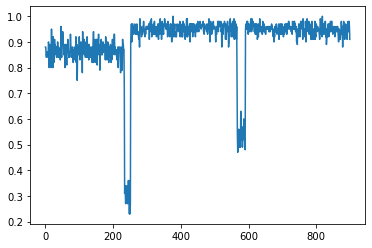

In [24]:
%matplotlib inline
plt.plot(score_list)